Task 2. Named entity recognition + image classification

In [52]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from pipeline.pipeline import PipelineExecution
import os
from PIL import Image
from PIL import UnidentifiedImageError

EDA: Animals10 Dataset

Converting a dataset with images to pandas dataframe

In [53]:
data_dir = 'data'
skip_folders = ['test', 'train', 'val']
data = []

for cls in os.listdir(data_dir):
    folder = os.path.join(data_dir, cls)
    #Skip system folders or unnecessary distributions
    if not os.path.isdir(folder) or cls in skip_folders:
        continue

    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        #Verifying that this is really an image
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        with Image.open(img_path) as img:
            data.append({
                'class': cls,
                'width': img.width,
                'height': img.height,
                'mode': img.mode
            })

df = pd.DataFrame(data)
df.head()

,class,width,height,mode
0,butterfly,426,640,RGB
1,butterfly,640,457,RGB
2,butterfly,426,640,RGB
3,butterfly,425,640,RGB
4,butterfly,426,640,RGB


Dataset Info

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   26179 non-null  object
 1   width   26179 non-null  int64 
 2   height  26179 non-null  int64 
 3   mode    26179 non-null  object
dtypes: int64(2), object(2)
memory usage: 818.2+ KB


Dataset contains 26179 images

Dataset Statistics

In [55]:
df.describe()

,width,height
count,26179.000000,26179.000000
mean,320.038810,252.630162
std,196.935326,148.403298
min,60.000000,57.000000
25%,300.000000,200.000000
50%,300.000000,225.000000
75%,300.000000,300.000000
max,6720.000000,6000.000000


During training, it will be necessary to bring all images to the same size so that this does not affect the quality of training

Class distribution

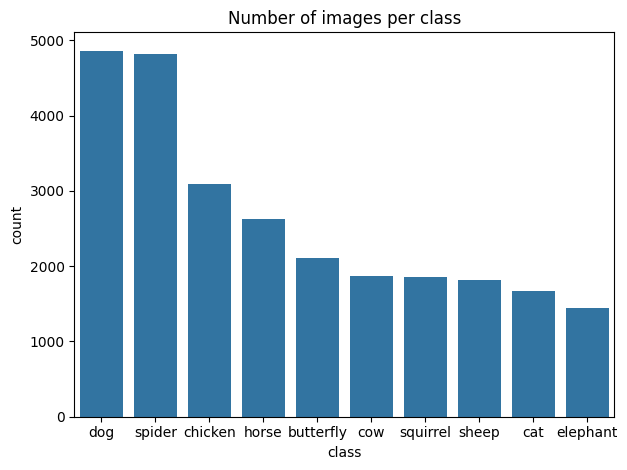

In [56]:
class_cout = df['class'].value_counts()
sns.barplot(class_cout)
plt.title("Number of images per class")
plt.tight_layout()

The distribution is a bit uneven, will need to pay attention to this when learning

Check data mode

In [57]:
data_mode = pd.unique(df['mode'])
data_mode

array(['RGB', 'RGBA', 'L', 'CMYK'], dtype=object)

In [58]:
df['mode'].value_counts()

mode
RGB     26128
RGBA       49
L           1
CMYK        1
Name: count, dtype: int64

Note: Using "tf.keras.utils.image_dataset_from_directory(...)" automatically converts images to RGB

Check for corrupted images

In [59]:
broken = []

for cls in os.listdir(data_dir):
    folder = os.path.join(data_dir, cls)
    if not os.path.isdir(folder) or cls in skip_folders:
        continue
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        try:
            Image.open(img_path).verify()
        except UnidentifiedImageError:
            broken.append(img_path)

print('Broken files', broken)

Broken files []


No broken files detected

Initialize Pipeline

In [60]:
detector = PipelineExecution()
sample_tests = [
    {"text": "I found a spider", "img_path": "data/val/spider/e83cb3062bf1003ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5edb3bd_640.jpg"},
    {"text": "There is a horse in the picture.", "img_path": "data/val/horse/OIP-_-5DDAGLz1A9FyrB0FLdgwHaFw.jpeg"},
    {"text": "This is a new dog", "img_path": "data/val/cow/OIP-_vfO5oTfXbYTmQa3fLqygwHaEK.jpeg"}
]

for test in sample_tests:
    prediction = detector.is_true(test['text'], test['img_path'])
    print(f"Text: {test['text']}")
    print(f"Image: {test['img_path']}")
    print(f"Match? {'Yes' if prediction == 1 else 'No'}\n")


Found 18322 files belonging to 10 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Text: I found a spider
Image: data/val/spider/e83cb3062bf1003ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5edb3bd_640.jpg
Match? Yes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Text: There is a horse in the picture.
Image: data/val/horse/OIP-_-5DDAGLz1A9FyrB0FLdgwHaFw.jpeg
Match? Yes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Text: This is a new dog
Image: data/val/cow/OIP-_vfO5oTfXbYTmQa3fLqygwHaEK.jpeg
Match? No



Edge cases

In [61]:
tests = [
    #Text without mentioning the animal    
    {"text": "The weather is good", "img_path": "data/val/cat/1940.jpeg"},
    #Synonyms / other forms
    {"text": "There is a kitten in the room", "img_path": "data/val/cat/1700.jpeg"},
    #Multiple mentions
    {"text": "A cat and a dog are playing", "img_path": "data/val/dog/OIP-_k_31g7jp-n1WA3oUrZnUQHaF0.jpeg"},
    #Spelling errors
    {"text": "I saw an elefant", "img_path": "data/val/elephant/OIP-1lvmWJyPLIuHCAHXUZ_MFQHaE8.jpeg"},
    #Empty text
    {"text": "", "img_path": "data/val/squirrel/OIP-_GGhpT1ecnjpxh5w86ainwHaE7.jpeg"},
    #Picture without animal
    {"text": "There is a cow", "img_path": "data/val/edge_cases/no_animals.jpg"},    
    #Picture with several animals
    {"text": "Cat and dog in the yard", "img_path": "data/val/edge_cases/cat-and-dog-together.jpg"},    
    #Class is missing from the dataset
    {"text": "I see a panda", "img_path": "data/val/edge_cases/panda.jpg"}
    
]

Run all edge cases through the pipeline

In [62]:
for test in tests:
    prediction = detector.is_true(test['text'], test['img_path'])
    print(f"Text: {test['text']}")
    print(f"Image path: {test['img_path']}")
    print(f"Match? {'Yes' if prediction == 1 else 'No'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Text: The weather is good
Image path: data/val/cat/1940.jpeg
Match? No
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Text: There is a kitten in the room
Image path: data/val/cat/1700.jpeg
Match? No
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Text: A cat and a dog are playing
Image path: data/val/dog/OIP-_k_31g7jp-n1WA3oUrZnUQHaF0.jpeg
Match? No
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Text: I saw an elefant
Image path: data/val/elephant/OIP-1lvmWJyPLIuHCAHXUZ_MFQHaE8.jpeg
Match? No
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Text: 
Image path: data/val/squirrel/OIP-_GGhpT1ecnjpxh5w86ainwHaE7.jpeg
Match? No
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Text: There is a cow
Image path: data/val/edge_cases/no_animals.jpg
Match? No
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Text: Cat and dog in the yard
Image path: data/val/edge_cases/cat-and-dog-together.jpg
Match? No
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Text: I see a panda
Image path: data/val/edge_cases/panda.jpg
Match? No


Current pipeline handles only single animals per image.
Plurals are handled partially; future improvements may include:
A small synonyms dictionary for text preprocessing
Multiple animal detection in a single image
More robust text matching (typos, lemmatization)